# Tutorial 1f  - Differentiable Ray Tracing Hello World

### May 2025

As you may have noticed, Optiland now supports swappable backends (as of now the options are: Numpy and PyTorch) that allow you to customize your workflow. Do you want to quickly design a simple system using traditional methods of numerical optimization? Choose numpy as the backend. Do you want to learn about differentiable ray tracing and how to combine Optiland with your ML/DL pipeline? Choose torch as the backend.

Throughout this notebook you will gain the necessary skills to learn how to swap backends, and how to use PyTorch for a simple optimization problem. Dial in :)

### Differentiable Ray Tracing - Basics 

Differentiable ray tracing **(DRT)** offers some notable advantages over traditional methodologies - especially when it comes to optimization. Conventional approaches generally involve applying small perturbations to design parameters and running discrete ray-tracing simulations repeatedly to estimate gradients. In contrast, DRT integrates **automatic differentiation** to compute these gradients directly and more efficiently by constructing a computational graph of the ray tracing process and then applying backpropagation.

Therefore, with a fully differentiable ray tracing pipeline, all the necessary steps (from ray intersections to refraction to image formation), are performed keeping in mind automatic differentiation. By enabling everything to be computed in an automatic differentiation framework like PyTorch, we allow the software to directly compute the gradient of our final merit function with respect to all the design parameters, which in turn opens the door to the usage of standard gradient-based algorithms like GD, SGD, Adam, etc (as opposed to relying on the finite difference approximations of the Jacobian, as in the standard DLS optimization algorithm).

That being said, let's get started with the practical application!

### 1. Changing the backend

In [1]:
# Begin by importing the backend module instead of numpy or torch directly
import optiland.backend as be

To switch to PyTorch:

In [2]:
# set backend
be.set_backend("torch")
be.set_device(
    "cpu"
)  # we will stick to cpu for now. "cuda" is also possible for GPU calculations.
print(be.get_precision())  # check the precision

# enable the gradient mode: to tell autograd to begin recording operations on a Tensor tensor
be.grad_mode.enable()

torch.float32


### 2. Design Workflow - from task to final optimized design

In this simple example, we are concerned with optimizing a singlet lens radii for achieving the smallest RMS spot size at a distance of 70 mm from the second surface of the lens.

In [3]:
from optiland.optic import Optic
from optiland.materials import Material
from optiland.analysis import SpotDiagram


class SingletConfigurable(Optic):
    """A configurable singlet lens."""

    def __init__(self, r1, r2, t2, material_name):
        super().__init__()
        ideal_material = Material(material_name)

        self.add_surface(index=0, radius=be.inf, thickness=be.inf)
        self.add_surface(
            index=1, thickness=7.0, radius=r1, is_stop=True, material=ideal_material
        )
        self.add_surface(index=2, radius=r2, thickness=t2)
        self.add_surface(index=3)

        self.set_aperture(aperture_type="EPD", value=25)

        self.set_field_type(field_type="angle")
        self.add_field(y=0.0)

        self.add_wavelength(value=0.55, is_primary=True)

Notice how you can build your singlet in a Class. This allows easy reproducibility and customization and extra calls.

Let's have a look what the lens look like at the moment.

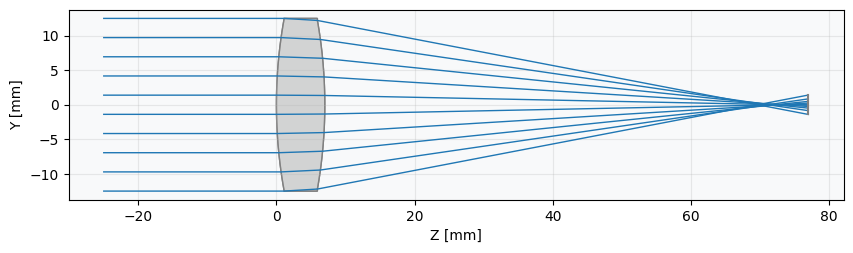

╒════╤═════════════════╤═══════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type            │ Comment   │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═════════════════╪═══════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar          │           │      inf │         inf │ Air        │       0 │       12.5      │
│  1 │ Stop - Standard │           │       70 │           7 │ BK7        │       0 │       12.5      │
│  2 │ Standard        │           │      -70 │          70 │ Air        │       0 │       12.0732   │
│  3 │ Planar          │           │      inf │         nan │ Air        │       0 │        0.668569 │
╘════╧═════════════════╧═══════════╧══════════╧═════════════╧════════════╧═════════╧═════════════════╛


In [4]:
lens = SingletConfigurable(r1=70.0, r2=-70.0, t2=70.0, material_name="BK7")
lens.draw(num_rays=10)
lens.info()

It is clear that the image plane is far from the best focus. Recall that here we assume the "best focus" to be the smallest possible RMS spot size. And, speaking of, let's now check it's actual value:


Initial RMS Spot Radius: 0.9442 mm


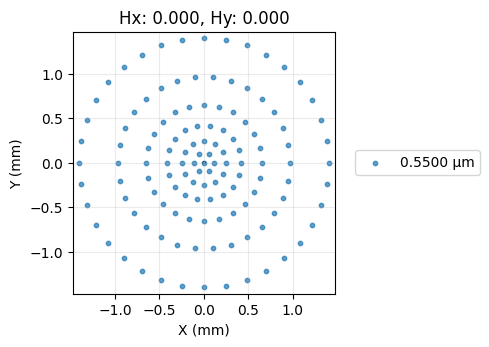

In [5]:
# RMS Spot Size Analysis
spot_diagram = SpotDiagram(lens)
rms_value = spot_diagram.rms_spot_radius()
print(f"\nInitial RMS Spot Radius: {rms_value[0][0]:.4f} mm")

# Spot Diagram visualization
spot_diagram.view(add_airy_disk=True)

Now, we set up the optimization to minimize the RMS spot size using PyTorch's autograd.
We need to:

1. Identify the parameters to optimize (Lens radii R1, R2).
2. Define a PyTorch optimizer (e.g., Adam).
3. Define the loss function (RMS spot radius).

In [6]:
import torch.optim as optim

# --- Parameter Handling ---

# Get initial values
radius1_param = lens.surface_group.surfaces[1].geometry.radius
radius2_param = lens.surface_group.surfaces[2].geometry.radius
params_to_optimize = [radius1_param, radius2_param]
print(params_to_optimize)

[tensor(70., requires_grad=True), tensor(-70., requires_grad=True)]


**NOTE:** When using the PyTorch backend with gradient mode enabled, Optiland allows direct access to certain geometric parameters (like surface radii) as tensors that participate in the computation graph. This enables us to pass them directly to a PyTorch optimizer.

In [7]:
# --- Optimizer ---
# We use the Adam optimizer, common for deep learning tasks.
# We pass the tensors we want to optimize.
learning_rate = 0.2  # Adjust as needed
optimizer = optim.Adam(params_to_optimize, lr=learning_rate)

In [8]:
# --- Loss Function ---
# The function to minimize is the RMS spot radius.
# We need a way to calculate this within the loop using the current tensor values.


def calculate_loss(lens):
    """Calculates the RMS spot radius for the current lens state."""
    rms_values_nested = SpotDiagram(lens).rms_spot_radius()
    rms_scalar = rms_values_nested[0][0]
    return rms_scalar


print("\nOptimization setup complete.")
print(f"Optimizing: R1, R2")
print(f"Initial values: (R1={radius1_param:.2f}, R2={radius2_param:.2f})")


# --- Optimization Loop ---
# We run the standard PyTorch training loop.

num_iterations = 100
print("\nStarting optimization...")
losses = []
for i in range(num_iterations):
    optimizer.zero_grad()

    # --- Calculate Loss ---
    loss = calculate_loss(lens)
    losses.append(loss.item())
    # --- Backpropagation and Optimization Step ---
    loss.backward()  # Calculate gradients
    optimizer.step()  # Update tensors based on gradients

    # --- Print Progress ---
    if (i + 1) % 25 == 0:
        print(
            f"Iteration {i + 1}/{num_iterations}, Loss (RMS Spot Radius): {loss.item():.6f} mm"
        )
        print(f"  R1: {radius1_param.item():.4f}, R2: {radius2_param.item():.4f}")

print("Optimization finished.")


Optimization setup complete.
Optimizing: R1, R2
Initial values: (R1=70.00, R2=-70.00)

Starting optimization...
Iteration 25/100, Loss (RMS Spot Radius): 0.263034 mm
  R1: 74.9251, R2: -74.9241
Iteration 50/100, Loss (RMS Spot Radius): 0.127734 mm
  R1: 76.8283, R2: -76.8953
Iteration 75/100, Loss (RMS Spot Radius): 0.115021 mm
  R1: 76.3996, R2: -76.6142
Iteration 100/100, Loss (RMS Spot Radius): 0.114965 mm
  R1: 76.2613, R2: -76.6589
Optimization finished.


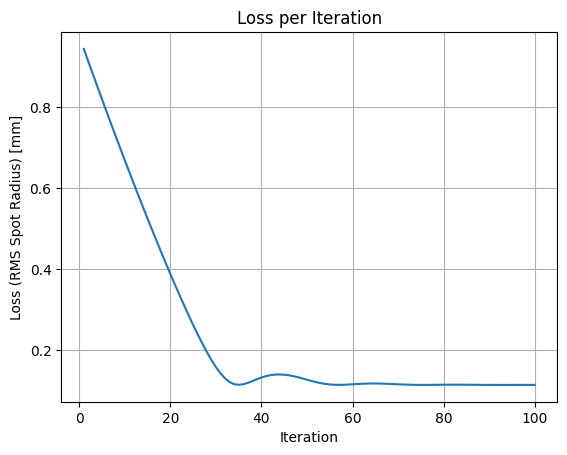

In [9]:
# --- Visualization of Loss per Epoch ---
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_iterations + 1), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss (RMS Spot Radius) [mm]")
plt.title("Loss per Iteration")
plt.grid(True)
plt.show()

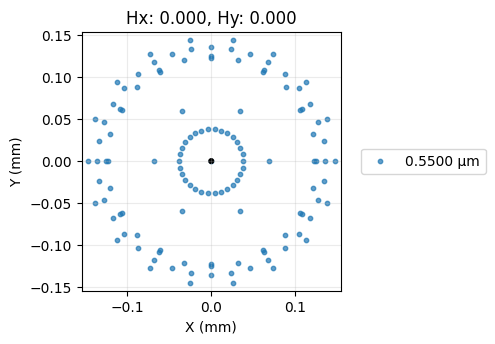

In [10]:
SpotDiagram(lens).view(add_airy_disk=True)

### Conclusion

Congratulations! You have successfully:

- Switched Optiland's computational backend to PyTorch.
- Defined a parameterized singlet lens model.
- Set up and executed a gradient-based optimization loop using PyTorch's `optim.Adam`.
- Leveraged Optiland's differentiable ray tracing capabilities to calculate the RMS spot size as the loss function.
- Observed how the optimizer iteratively adjusted the lens radii (and potentially thickness) to significantly minimize the RMS spot size, improving the lens's focus quality.

This tutorial demonstrates the power of combining automatic differentiation frameworks like PyTorch with optical simulations. By directly accessing gradients through the differentiable ray tracer, we can use efficient optimization algorithms standard in machine learning for optical design tasks.

**Next Steps:**

- Experiment with optimizing different parameters (e.g., conic constants, different thicknesses).
- Try different PyTorch optimizers or learning rates.
- Define a more complex merit function incorporating other aberrations or constraints.
- Explore using the GPU (`be.set_device('cuda')`) for potentially faster optimization, especially with more complex systems or larger ray sets.
- Check out the gallery examples for more educative design examples that leverage the DRT!